# 2.4 均值回归择股策略
假设股票价值都会围绕着均线波动，不会偏离太大。如果偏离太大就会有上升/下跌的趋势。选择股票池中偏离程度最大的n只股票进行调仓。这里的偏离程度需要自己定义。这里定义的ratio = (ma - p) / ma，调仓时寻找ratio最大的n只股票。ma是m天(m是超参数，本文取30)均值，p是当天的开盘价。思路是如果当天的开盘价偏离均线过多，则调进仓。

In [ ]:
def initialize(context):
    set_benchmark('000300.XSHG')
    set_option('use_real_price', True)
    set_order_cost(OrderCost(open_tax=0, close_tax=0.001, \
    open_commission=0.0003, close_commission=0.0003, \
    close_today_commission=0, min_commission=5),type='stock')
    
    g.security = get_index_stocks('000300.XSHG')
   
    g.ma_days = 30
    g.stock_num = 10
    
    run_monthly(handle,1) # 自带的每月运行一次的函数
    
def handle(context):
    # 计算偏离程度
    sr = pd.Series(index = g.security)
    for stock in sr.index:
        ma = attribute_history(stock, g.ma_days)['close'].mean()
        p = get_current_data()[stock].day_open # 这只stock当头的开盘价
        ratio = (ma - p )/ma
        sr[stock] = ratio
        
    to_hold = sr.nlargest(g.stock_num).index
    
    for stock in context.portfolio.positions:
        if stock not in to_hold:
            order_target(stock,0)
    
    to_buy = [stock for stock in to_hold \
    if stock not in context.portfolio.positions]
    
    if len(to_buy)>0:
        cash_per_stock = context.portfolio.available_cash / len(to_buy)
        for stock in to_buy:
            order_value(stock, cash_per_stock)
   

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams["font.sans-serif"] = ["SimHei"]
mpl.rcParams["axes.unicode_minus"] = False

import numpy as np
import pandas as pd
data = pd.read_csv('/data/量化交易策略回测结果/2.4均值回归择股策略.csv',encoding = 'ansi')
data.head()

,时间,基准收益,策略收益,当日盈利,当日亏损,当日买入,当日卖出,超额收益(%)
0,2022-10-10 16:00:00,-2.21,-3.04,0.0,-3036.0,71625,0,-0.85
1,2022-10-11 16:00:00,-2.03,-3.72,0.0,-684.0,0,0,-1.73
2,2022-10-12 16:00:00,-0.54,-1.53,2188.0,0.0,0,0,-1.00
3,2022-10-13 16:00:00,-1.37,-2.27,0.0,-733.0,0,0,-0.91
4,2022-10-14 16:00:00,0.99,0.50,2762.0,0.0,0,0,-0.49


In [4]:
data.tail()
# 时间段是2022-10-10到2023-03-31

,时间,基准收益,策略收益,当日盈利,当日亏损,当日买入,当日卖出,超额收益(%)
114,2023-03-27 16:00:00,5.46,28.04,326.0,0.0,0,0,21.41
115,2023-03-28 16:00:00,5.11,27.25,0.0,-790.0,0,0,21.06
116,2023-03-29 16:00:00,5.29,27.70,459.0,0.0,0,0,21.28
117,2023-03-30 16:00:00,6.14,28.19,489.0,0.0,0,0,20.77
118,2023-03-31 16:00:00,6.47,26.56,0.0,-1637.0,0,0,18.87


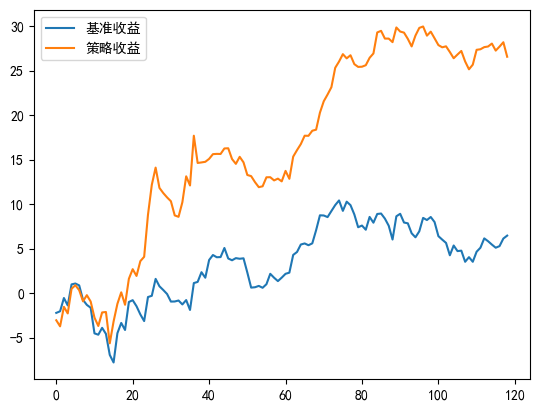

In [2]:
data[['基准收益', '策略收益']].plot()
plt.show()